# Deep learning volatility

In [1]:
%config Completer.use_jedi=False

import os
os.chdir('Data')
# import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import csv
import pandas as pd

import scipy

In [48]:
# df = np.loadtxt("parameters_impliedVols.txt")

df62 = np.loadtxt('impliedVols_server62_market.txt')
# df = np.concatenate((df62, df70, df70_min))
df = df62.copy()
print(df.shape)
# np.savetxt("parameters_impliedVols.txt", df, fmt="%.4f")
xx=df[:,:6]
yy=df[:,6:]
print(xx.shape, yy.shape)
xx[0], yy[0][:11]

(26120, 94)
(26120, 6) (26120, 88)


(array([0.6863, 1.3481, 0.5816, 0.2573, 0.0039, 0.2392]),
 array([0.1068, 0.101 , 0.0947, 0.0884, 0.0822, 0.0766, 0.0719, 0.0683,
        0.0663, 0.0664, 0.0683]))

In [65]:
### maturities and strikes for the Neural Network
maturities = np.array([0.1, 0.2, 0.3, 0.5, 0.75, 1.0, 1.5, 2.0])
strikes = np.array([95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105])
logmonyness = np.log(strikes/100)
strike_dim = len(strikes)
maturities_dim = len(maturities)

### maturities and strikes on the market
maturities_market = np.array([0.06, 0.15, 0.31, 0.56])
strikes_market = np.array([5.25, 5.50, 5.75, 6.00, 6.25])
logmonyness_market = np.log(strikes_market/5.24)

### Market data of 4*5 dimensions
df_market = np.loadtxt('market_implied_vols.txt')
print(df_market.shape)

(285, 20)


In [62]:
#remove invalid paramters
invalid = np.where(yy == yy.min())[0]
xx = np.delete(xx, (invalid), axis=0)
yy = np.delete(yy, (invalid), axis=0)
xx.shape, yy.shape

((26044, 6), (26044, 88))

$$
\begin{aligned}
dS_t &= S_t\sqrt{V_t}dW_t,\\
dV_t &= \kappa(\theta-V_t)dt + \nu\sqrt{V_t}dB_t
\end{aligned}
$$

# Step 1: Data Generation


### **Inputs:** 
####  1. $\nu_{0}$ spot variance 
####  2. $\rho$ spot-vol correlation,
####  3. $\sigma$ vol of vol
####  4. $\theta$ long term vol
####  5. $\kappa$ speed of mean reversion 
    
    
### **Outputs:**
#### Implied volatility surface (11x8=88 points)

## Scaling:

### Model Parameters $\theta\to scale(\theta)\in[0,1]$
$$scale(\theta^i)=\frac{(\theta^i-\theta^i_{min})}{\theta^i_{max}-\theta^i_{min}},\quad i \in |\Theta|$$

### Implied volatilities
$$scale(\sigma_{BS}^{i,j})=\frac{\sigma_{BS}^{i,j}-\mathbb{E}[\sigma_{BS}^{i,j}]}{std(\sigma_{BS}^{i,j})},\quad i\in\text{Maturities},\; j\in \text{Strikes}$$

In [67]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    xx, yy, test_size=0.15, random_state=42)
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scale = StandardScaler()
y_train_transform = scale.fit_transform(y_train)
y_test_transform = scale.transform(y_test)

scale_market = StandardScaler()
y_market_transform = scale_market.fit_transform(df_market)

# scale_mm = MinMaxScaler()
# x_train_transform = scale_mm.fit_transform(X_train)
# x_test_transform = scale_mm.transform(X_test)
# df_market

$\alpha\in[0.005, 0.2],\; \lambda\in[0.1, 2.0],\; a\in[0.1, 1.0],\; b\in[0.01, 1.0],\; c\in[0.0001, 0.01],\; Z0\in[0.01, 0.3]$

In [5]:
ub=np.max(xx, axis=0)
lb=np.min(xx, axis=0)

def myscale(x):
    res=np.zeros(6)
    for i in range(6):
        res[i]=(x[i] - (ub[i] + lb[i])*0.5) * 2 / (ub[i] - lb[i])
        
    return res
def myinverse(x):
    res=np.zeros(6)
    for i in range(6):
        res[i]=x[i]*(ub[i] - lb[i]) *0.5 + (ub[i] + lb[i])*0.5
        
    return res

In [6]:
x_train_transform = np.array([myscale(x) for x in X_train])
x_test_transform = np.array([myscale(x) for x in X_test])
x_test_transform.shape

(3907, 6)

# Step 2. Create the Neural Network

In [115]:
import keras
from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
keras.backend.set_floatx('float64')


input1 = keras.layers.Input(shape=(6,))
x1 = keras.layers.Dense(30,activation = 'elu')(input1)
x2=keras.layers.Dense(30,activation = 'elu')(x1) 
x3=keras.layers.Dense(30,activation = 'elu')(x2) 


x4=keras.layers.Dense(88,activation = 'linear')(x3)


modelGEN = keras.models.Model(inputs=input1, outputs=x4)
modelGEN.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 6)]               0         
_________________________________________________________________
dense_8 (Dense)              (None, 30)                210       
_________________________________________________________________
dense_9 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_10 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_11 (Dense)             (None, 88)                2728      
Total params: 4,798
Trainable params: 4,798
Non-trainable params: 0
_________________________________________________________________


# Step 3. Fit the Neural Network (No need to run the code, parameters are stored on a .h5 file)

In [116]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))
modelGEN.compile(loss = root_mean_squared_error, optimizer = "adam")



In [117]:
modelGEN.fit(x_train_transform, y_train, 
             batch_size=32,
#              validation_split = 0.2,
             validation_data = (x_test_transform, y_test),
             epochs = 100, verbose = True,shuffle=1)#,callbacks=[earlystop])

Epoch 1/100
692/692 [==============================] - 1s 1ms/step - loss: 0.0243 - val_loss: 0.0101
Epoch 2/100
692/692 [==============================] - 1s 1ms/step - loss: 0.0078 - val_loss: 0.0071
Epoch 3/100
692/692 [==============================] - 1s 1ms/step - loss: 0.0059 - val_loss: 0.0068
Epoch 4/100
692/692 [==============================] - 1s 1ms/step - loss: 0.0052 - val_loss: 0.0052
Epoch 5/100
692/692 [==============================] - 1s 1ms/step - loss: 0.0047 - val_loss: 0.0047
Epoch 6/100
692/692 [==============================] - 1s 1ms/step - loss: 0.0044 - val_loss: 0.0037
Epoch 7/100
692/692 [==============================] - 1s 1ms/step - loss: 0.0041 - val_loss: 0.0038
Epoch 8/100
692/692 [==============================] - 1s 1ms/step - loss: 0.0039 - val_loss: 0.0041
Epoch 9/100
692/692 [==============================] - 1s 1ms/step - loss: 0.0038 - val_loss: 0.0041
Epoch 10/100
692/692 [==============================] - 1s 1ms/step - loss: 0.0036 - val_lo

### Store/Load optimal NN parameteres

In [118]:
modelGEN.save_weights('HestonNNWeights.h5')

In [119]:
modelGEN.load_weights('HestonNNWeights.h5')

In [120]:
NNParameters=[]
for i in range(1,len(modelGEN.layers)):
    NNParameters.append(modelGEN.layers[i].get_weights())

# Step 4. Optimisation
### (Numpy Implementation of the Neural Network tends to be faster than Keras)

Here the *elu* function writes:
$$elu(x) = \begin{cases}e^{x}-1,\; x<0\\
x,\; x\geq 0.
\end{cases}$$

In [122]:
NumLayers=3
def elu(x):
    #Careful function ovewrites x
    ind=(x<0)
    x[ind]=np.exp(x[ind])-1
    return x
def eluPrime(y):
    # we make a deep copy of input x
    x=np.copy(y)
    ind=(x<0)
    x[ind]=np.exp(x[ind])
    x[~ind]=1
    return x
def NeuralNetwork(x):
    input1=x
    for i in range(NumLayers):
        input1=np.dot(input1,NNParameters[i][0])+NNParameters[i][1]
        #Elu activation
        input1=elu(input1)
    #The output layer is linnear
    i+=1
    return np.dot(input1,NNParameters[i][0])+NNParameters[i][1]
def NeuralNetworkGradient(x):
    input1=x
    #Identity Matrix represents Jacobian with respect to initial parameters
    grad=np.eye(6)
    #Propagate the gradient via chain rule
    for i in range(NumLayers):
        input1=(np.dot(input1,NNParameters[i][0])+NNParameters[i][1])
        grad=(np.einsum('ij,jk->ik', grad, NNParameters[i][0]))
        #Elu activation
        grad*=eluPrime(input1)
        input1=elu(input1)
    #input1.append(np.dot(input1[i],NNParameters[i+1][0])+NNParameters[i+1][1])
#     grad=np.einsum('ij,jk->ik',grad,NNParameters[i+1][0])
    grad=np.dot(grad,NNParameters[i+1][0])
    #grad stores all intermediate Jacobians, however only the last one is used here as output
    return grad

# Compute Implied vol relative errors on Test set

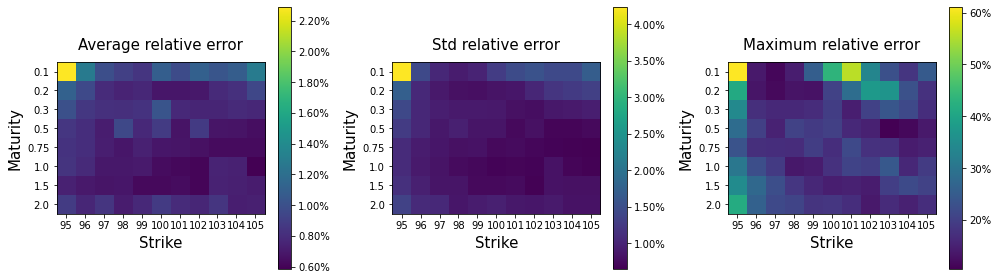

In [123]:
##### AVERAGE VALUES #######
X_sample = x_test_transform
y_sample = y_test

# prediction=[scale.inverse_transform(modelGEN.predict(X_sample[i].reshape(1,6))[0]) for i in range(len(X_sample))]
prediction=[modelGEN.predict(X_sample[i].reshape(1,6))[0] for i in range(len(X_sample))]

plt.figure(1,figsize=(14,4))
ax=plt.subplot(1,3,1)
err = np.mean(100*np.abs((y_sample-prediction)/y_sample),axis = 0)
plt.title("Average relative error",fontsize=15,y=1.04)
plt.imshow(err.reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())

ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)

ax=plt.subplot(1,3,2)
err = 100*np.std(np.abs((y_sample-prediction)/y_sample),axis = 0)
plt.title("Std relative error",fontsize=15,y=1.04)
plt.imshow(err.reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)

ax=plt.subplot(1,3,3)
err = 100*np.max(np.abs((y_sample-prediction)/y_sample),axis = 0)
plt.title("Maximum relative error",fontsize=15,y=1.04)
plt.imshow(err.reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
plt.tight_layout()
# plt.savefig('HestonNNErrors.png', dpi=300)
plt.show()


# Plot sample Smiles

[0.5149 1.0186 0.2276 0.4524 0.0047 0.2228]


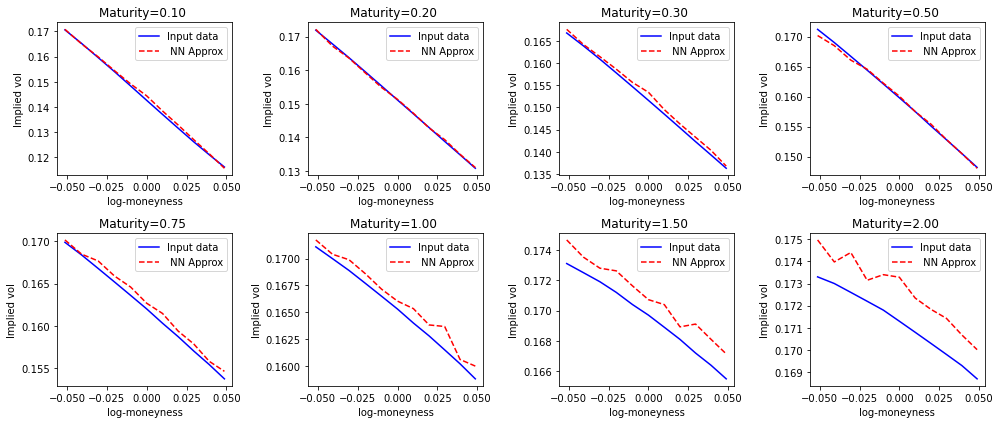

[0.6938 0.8876 0.6959 0.0816 0.0019 0.2857]


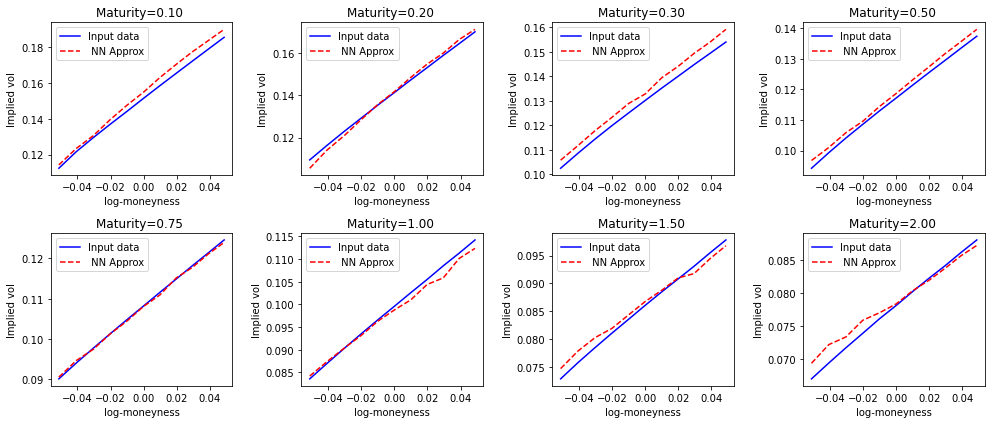

[0.6846 1.4085 0.1995 0.0756 0.0093 0.1123]


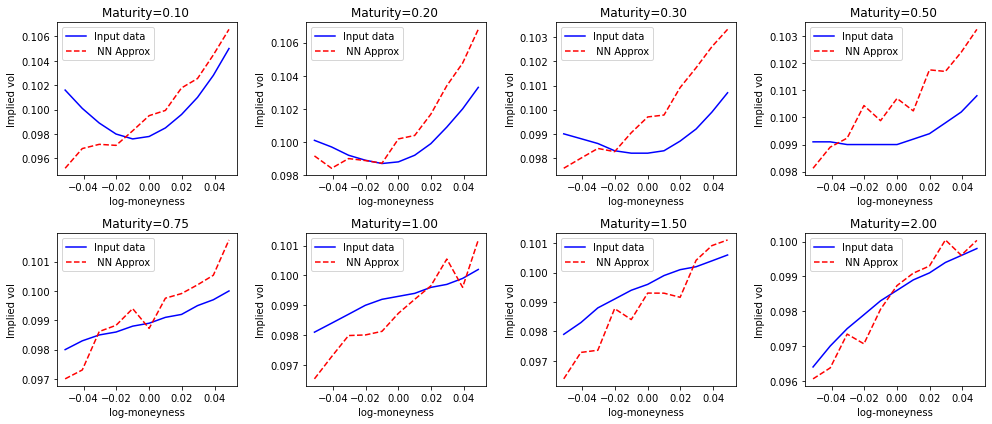

[0.5523 1.2535 0.4624 0.4744 0.0042 0.1972]


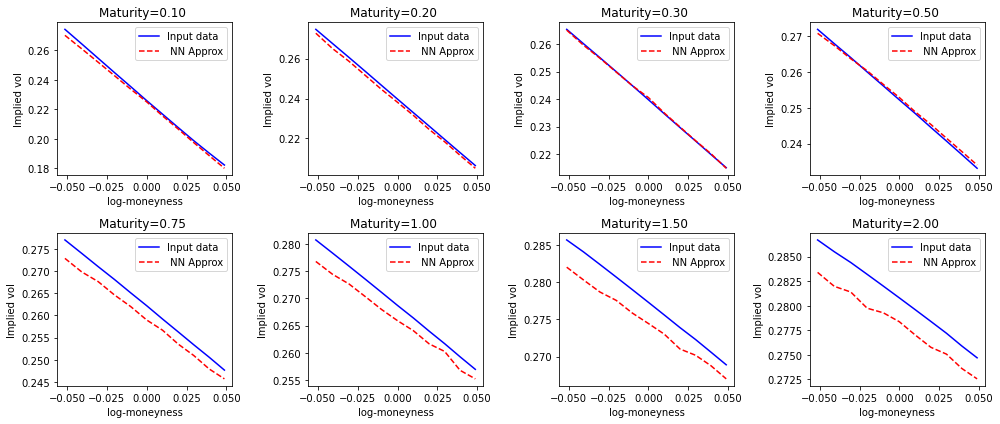

[0.642  1.3436 0.3649 0.1961 0.0039 0.0902]


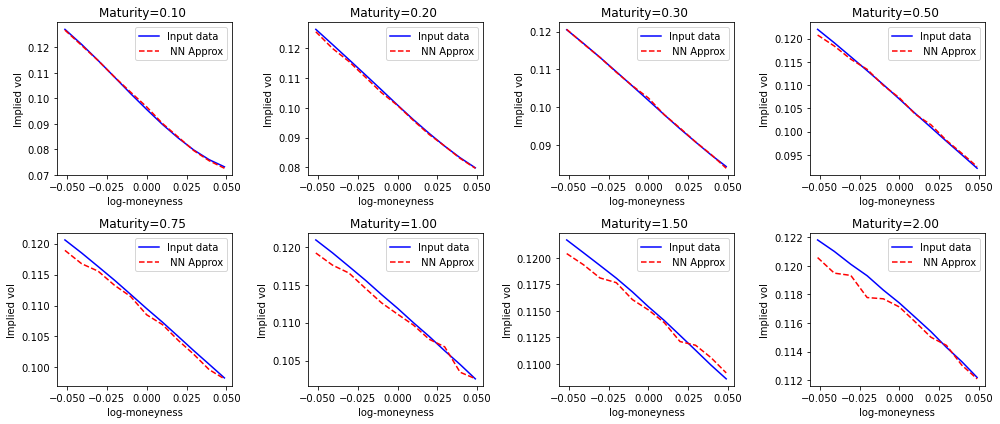

[0.5383 1.0638 0.5667 0.2313 0.0056 0.136 ]


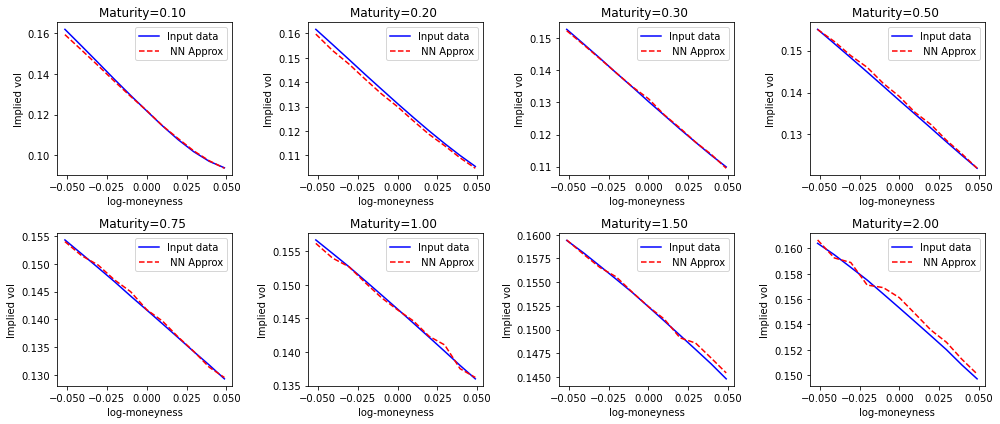

[6.9940e-01 1.1804e+00 7.4760e-01 3.2990e-01 7.0000e-04 2.2260e-01]


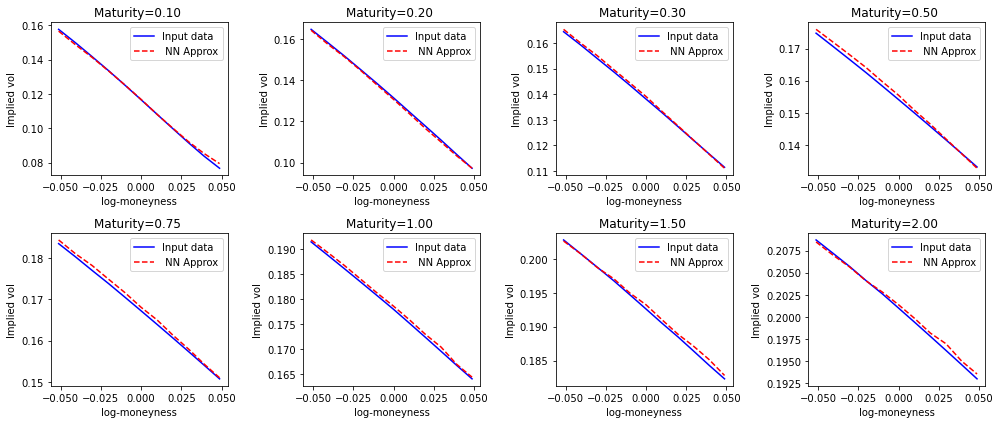

[0.5363 1.1702 0.3629 0.2658 0.0023 0.2597]


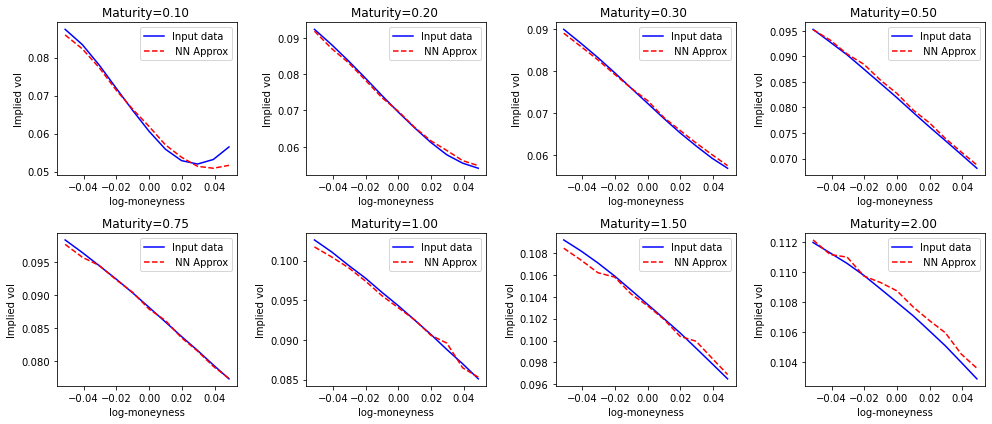

[0.643  0.7614 0.5913 0.2941 0.0081 0.1917]


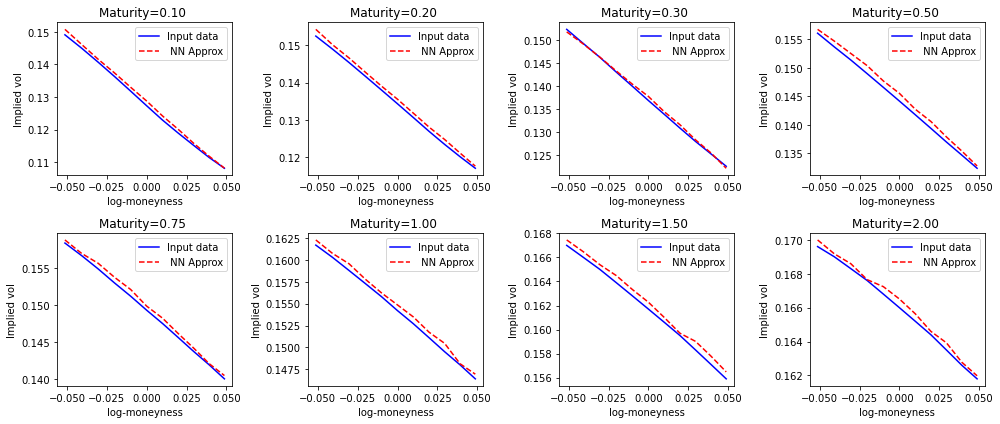

[0.5762 1.218  0.2315 0.45   0.0053 0.2507]


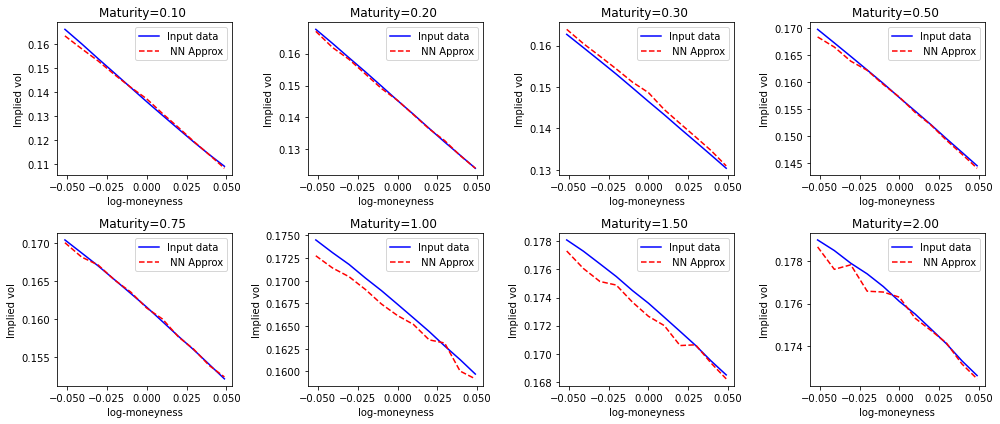

[0.685  1.4725 0.7252 0.3438 0.0067 0.2184]


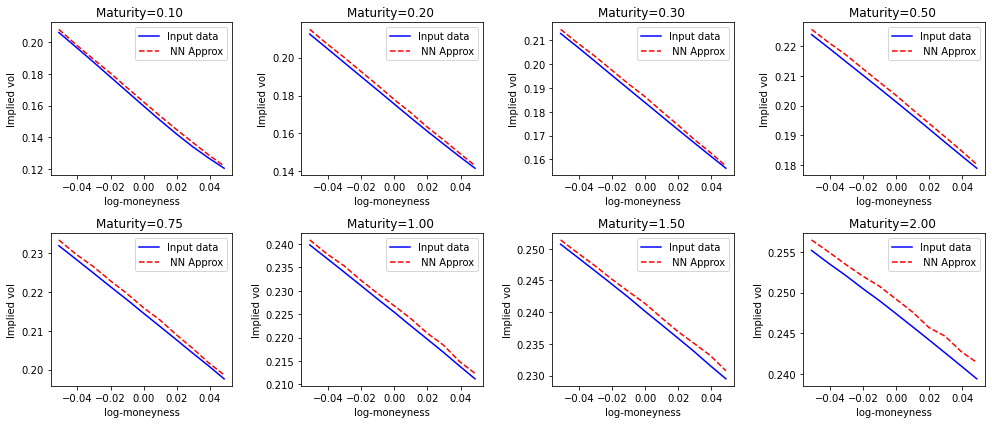

[0.5256 0.9064 0.4848 0.2795 0.0017 0.2923]


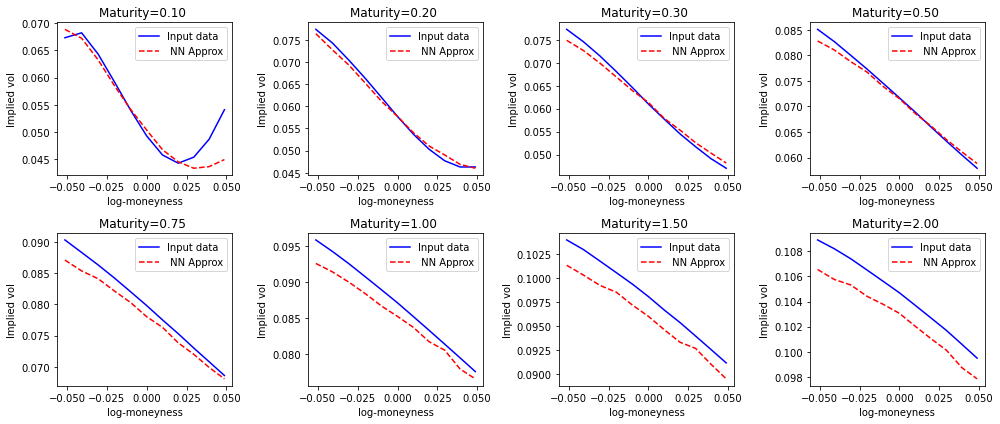

[0.6747 0.6042 0.5781 0.2561 0.0027 0.2069]


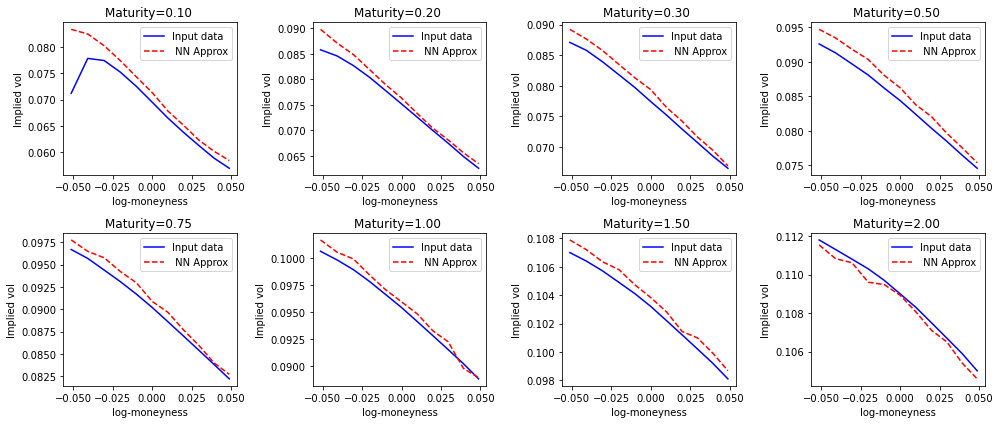

[0.5952 0.5545 0.2728 0.4124 0.0027 0.2806]


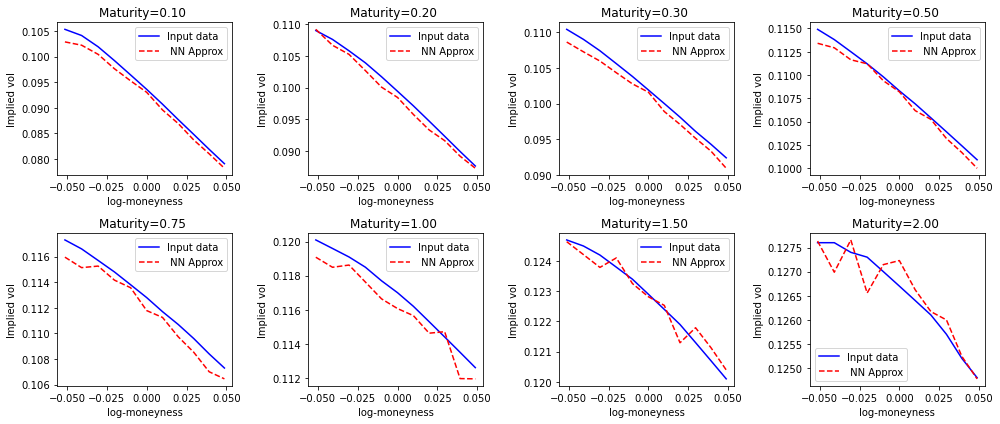

[0.6562 1.2051 0.5549 0.3493 0.0082 0.0787]


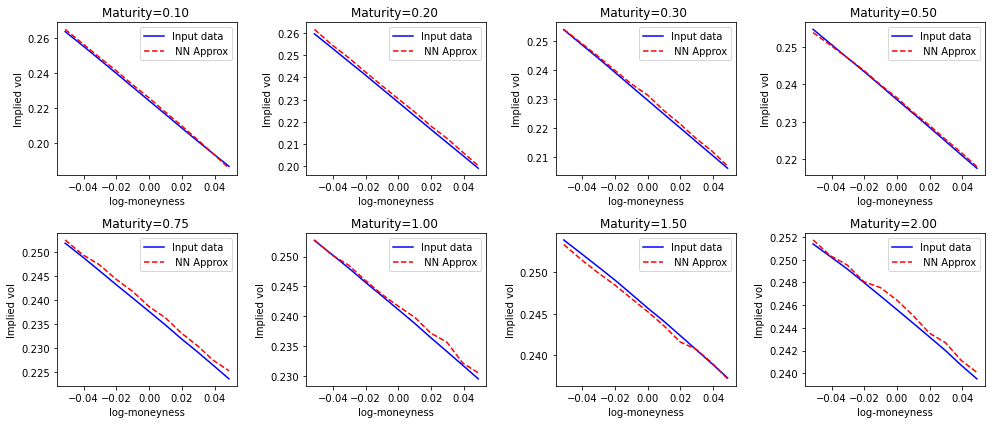

[6.9620e-01 1.3238e+00 6.7880e-01 4.8520e-01 1.1000e-03 8.2300e-02]


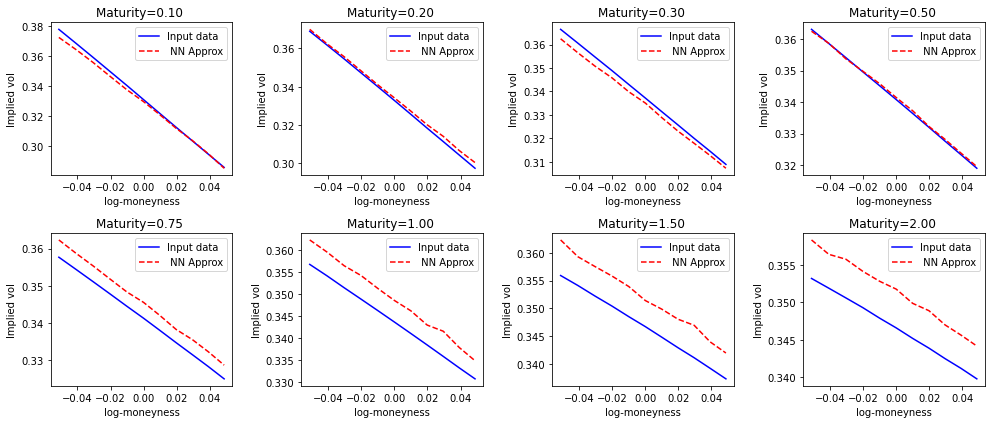

[0.6205 0.6066 0.4593 0.3574 0.0039 0.14  ]


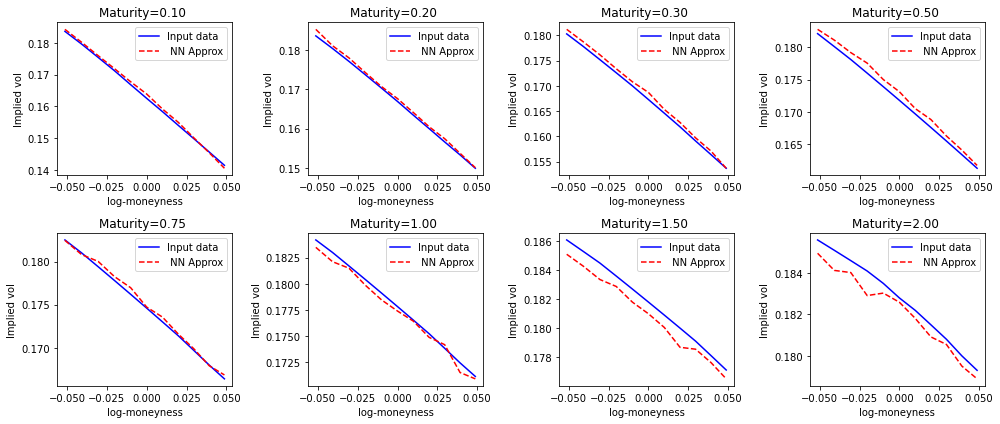

[0.6167 1.0627 0.3066 0.2208 0.0054 0.1731]


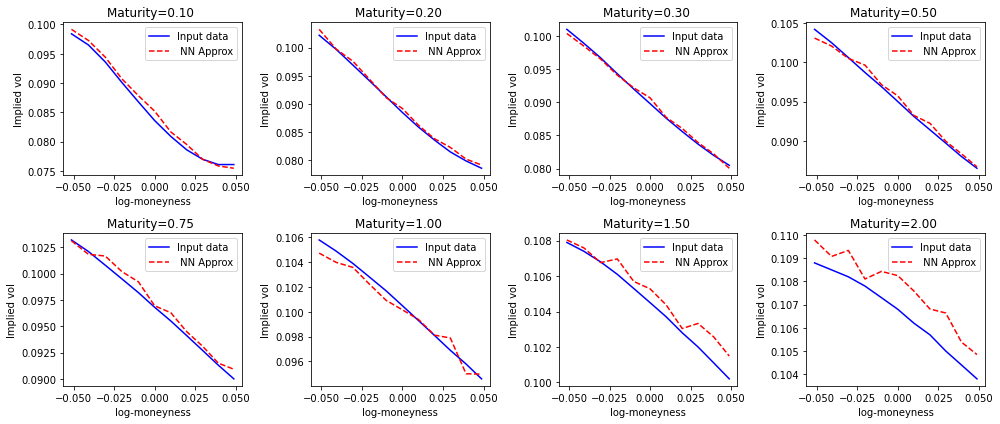

[0.6979 0.6191 0.1705 0.3793 0.0043 0.0828]


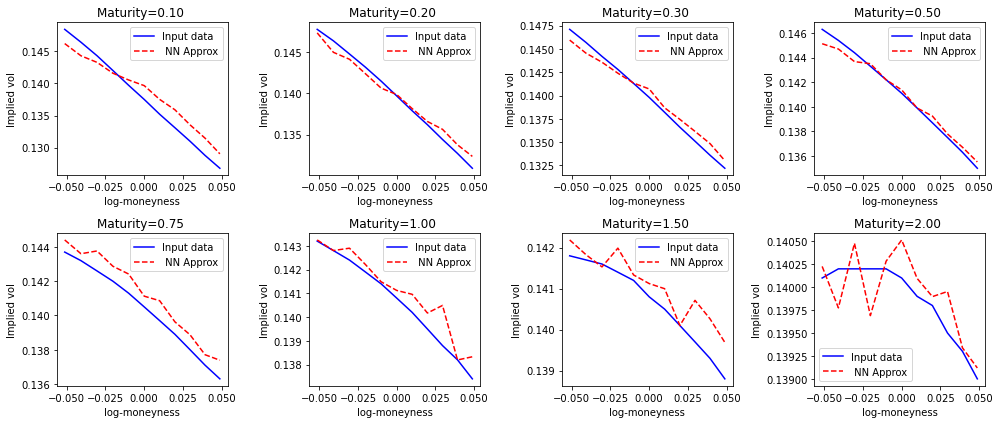

[0.5921 0.7291 0.6075 0.1774 0.0065 0.0834]


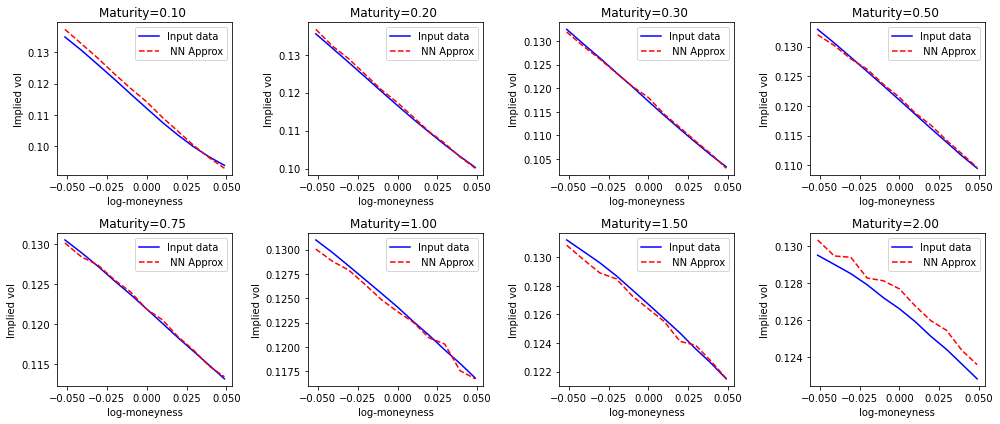

In [124]:
import time
for i in range(20):
    sample_ind = 5*i+1000
    X_sample = x_test_transform[sample_ind]
    y_sample = y_test[sample_ind]
    print(X_test[sample_ind])
    prediction=modelGEN.predict(X_sample.reshape(1,6))[0]
#     prediction=scale.inverse_transform(modelGEN.predict(X_sample.reshape(1,6))[0])
    plt.figure(1,figsize=(14,6))
    for i in range(maturities_dim):
        plt.subplot(2,4,i+1)

        plt.plot(logmonyness, y_sample[i*strikes_dim:(i+1)*strikes_dim],'b',label="Input data")
        plt.plot(logmonyness, prediction[i*strikes_dim:(i+1)*strikes_dim],'--r',label=" NN Approx")


        plt.title("Maturity=%1.2f "%maturities[i])
        plt.xlabel("log-moneyness")
        plt.ylabel("Implied vol")

        plt.legend()
    plt.tight_layout()
    plt.show()
#     time.sleep(5)
    

# Use gradient methods for optimisation

In [21]:
def CostFunc(x,sample_ind):
    return np.sum(np.power((NeuralNetwork(x)-y_test_transform[sample_ind]),2))
def Jacobian(x,sample_ind):
    return 2*np.sum((NeuralNetwork(x)-y_test_transform[sample_ind])*NeuralNetworkGradient(x),axis=1)
#Cost Function for Levenberg Marquardt
def CostFuncLS(x,sample_ind):
    return (NeuralNetwork(x)-y_test_transform[sample_ind])

def JacobianLS(x,sample_ind):
    return NeuralNetworkGradient(x).T

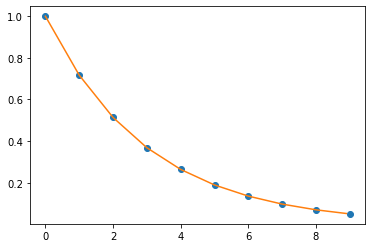

In [37]:
from scipy.interpolate import interp1d, griddata, interp2d
x = np.arange(0, 10)
y = np.exp(-x/3.0)
f = interp1d(x, y)
xnew = np.arange(0, 9, 0.1)
ynew = f(xnew)   # use interpolation function returned by `interp1d`
plt.plot(x, y, 'o', xnew, ynew, '-')
plt.show()

In [125]:
def CostFunc(x,sample_ind):
    f = interp2d(maturities, logmonyness, NeuralNetwork(x))
    prediction_market = f(maturities_market, logmonyness_market).ravel()
    return np.sum(np.power((prediction_market-df_market[sample_ind]),2))

def Jacobian(x,sample_ind):
    f = interp2d(maturities, logmonyness, NeuralNetwork(x))
    prediction_market = f(maturities_market, logmonyness_market).ravel()
    gradient = np.zeros((6, 20))
    for i in range(6):
        df = interp2d(maturities, logmonyness, NeuralNetworkGradient(x)[i])
        gradient[i] = df(maturities_market, logmonyness_market).ravel()
    return 2*np.sum((prediction_market-df_market[sample_ind])*gradient,axis=1)

# #Cost Function for Levenberg Marquardt

def CostFuncLS(x,sample_ind):
    f = interp2d(maturities, logmonyness, NeuralNetwork(x))
    prediction_market = f(maturities_market, logmonyness_market).ravel()
    
    return (prediction_market-df_market[sample_ind])

def JacobianLS(x,sample_ind):
    gradient = np.zeros((6, 20))
    for i in range(6):
        df = interp2d(maturities, logmonyness, NeuralNetworkGradient(x)[i])
        gradient[i] = df(maturities_market, logmonyness_market).ravel()
    
    return gradient.T

In [142]:
Approx=[]
Timing = []

solutions=np.zeros([3,6])
init=np.zeros([3, 6])
times = np.zeros(3)
for i in range(len(df_market)):
    disp=str(i+1)+"/" + str(len(df_market))
    print (disp, end="\r")
    start= time.time()
    I=scipy.optimize.minimize(CostFunc,x0=init[0],args=i,method='SLSQP', jac=Jacobian,tol=1E-10,options={"maxiter":5000})
    end= time.time()
    solutions[0,:]=myinverse(I.x)
    init[0] = I.x
    times[0]=end-start
    
    start= time.time()
    I=scipy.optimize.minimize(CostFunc,x0=init[1],args=i,method='L-BFGS-B', jac=Jacobian,tol=1E-10,options={"maxiter":5000})
    end= time.time()
    solutions[1,:]=myinverse(I.x)
    init[1] = I.x
    times[1]=end-start
    #Levenberg-Marquardt
    start= time.time()
    I=scipy.optimize.least_squares(CostFuncLS, init[2], JacobianLS, method='lm', args=(i,),gtol=1E-10)
    end= time.time()
#     print(I.x.shape)
    solutions[2, :]=myinverse(I.x)
    times[2] = end-start
    init[2]= I.x
    
    Approx.append(np.copy(solutions))
    Timing.append(np.copy(times))
    
print("time spent: %ss"%np.round(np.sum(Timing, axis=0), 6))
# print("solution: ", np.round(np.mean(Approx, axis=0), 6))

time spent: [22.226667 18.049873 64.593932]s


In [143]:
for j in range(3):
    print(np.mean([Approx[i][j] for i in range(len(Approx))], axis=0))

[ -3.90644547 -19.90176753  -2.4027656    2.07586725   0.05015961
  -0.54165263]
[ -0.99629581 -14.49925658  -2.95835972   2.6345578    0.03477227
  -1.17958566]
[-2.62887442e+00 -1.75256667e+01 -2.48897916e+00  3.82522776e+00
 -2.55112307e-03  1.41177729e+00]


In [23]:
import time

Approx=[]
Timing = []

solutions=np.zeros([3,6])
init=np.zeros(6)
times = np.zeros(3)
for i in range(len(X_test)):
    disp=str(i+1)+"/" + str(len(X_test))
    print (disp, end="\r")
    start= time.time()
    I=scipy.optimize.minimize(CostFunc,x0=init,args=i,method='SLSQP', jac=Jacobian,tol=1E-10,options={"maxiter":5000})
    end= time.time()
    solutions[0,:]=myinverse(I.x)
    times[0]=end-start
    
    start= time.time()
    I=scipy.optimize.minimize(CostFunc,x0=init,args=i,method='L-BFGS-B', jac=Jacobian,tol=1E-10,options={"maxiter":5000})
    end= time.time()
    solutions[1,:]=myinverse(I.x)
    times[1]=end-start
    #Levenberg-Marquardt
    start= time.time()
    I=scipy.optimize.least_squares(CostFuncLS, init, JacobianLS, method='lm', args=(i,),gtol=1E-10)
    end= time.time()
#     print(I.x.shape)
    solutions[2, :]=myinverse(I.x)
    times[2] = end-start
    
    Approx.append(np.copy(solutions))
    Timing.append(np.copy(times))
    
print("time spent: %ss"%np.round(np.sum(Timing, axis=0), 6))
# print("solution: ", np.round(np.mean(Approx, axis=0), 6))

time spent: [77.98889  83.225045 11.597509]s


In [24]:
for j in range(3):
    print(np.mean([Approx[i][j] for i in range(len(Approx))], axis=0)) 



[0.58628205 0.96269732 0.44634485 0.28913538 0.00567159 0.15220602]
[0.59441884 0.98813841 0.44461232 0.29065202 0.0058347  0.15612329]
[0.58637046 0.92989733 0.4256586  0.29076453 0.0057949  0.13547099]


## Calibration on market data

In [25]:
def CostFunc_(x, sample_ind):
    return np.sum(np.power((NeuralNetwork(x) - market_iv_transform[sample_ind]).reshape(1,20),2))
def Jacobian_(x, sample_ind):
#     print(NeuralNetworkGradient(x).shape)
    return 2*np.sum((NeuralNetwork(x) - market_iv_transform[sample_ind])*NeuralNetworkGradient(x),axis=1)
def CostFuncLS_(x, sample_ind):
    return (NeuralNetwork(x) - market_iv_transform[sample_ind])
def JacobianLS_(x, sample_ind):
    return NeuralNetworkGradient(x).T

In [26]:
#import market implied vols
market_iv_transform = scale.transform(np.loadtxt('market_implied_vols.txt'))
init = np.zeros(6)
result1 = []
result2 = []
result3 = []

for i in range(len(market_iv)):
    I=scipy.optimize.minimize(CostFunc_,x0=init,method='SLSQP', jac=Jacobian_,  args=(i), tol=1E-10,options={"maxiter":5000})
    result1.append(myinverse(I.x))
    I=scipy.optimize.minimize(CostFunc,x0=init,args=i,method='L-BFGS-B',jac=Jacobian,tol=1E-10,options={"maxiter":5000})
    result2.append(myinverse(I.x))
    I=scipy.optimize.least_squares(CostFuncLS_, init, JacobianLS_, method='lm',args=(i,),gtol=1E-10)
    result3.append(myinverse(I.x))
np.mean(result1, axis=0), np.mean(result2, axis=0),np.mean(result3, axis=0)

ValueError: X has 20 features, but StandardScaler is expecting 88 features as input.

# Save the Lavenberg-Marquardt Optimal parameters

In [27]:
LMParameters=np.array([Approx[i][0] for i in range(len(Approx))])
np.savetxt("NNParametersQuadraticRoughHeston.txt",LMParameters)
LMParameters = np.loadtxt("NNParametersQuadraticRoughHeston.txt")
LMParameters.shape
np.mean(LMParameters, axis=0)
# Approx[0][0], Approx[0][1]

array([0.58628205, 0.96269732, 0.44634485, 0.28913538, 0.00567159,
       0.15220602])

# Calibration Errors with Levenberg-Marquardt

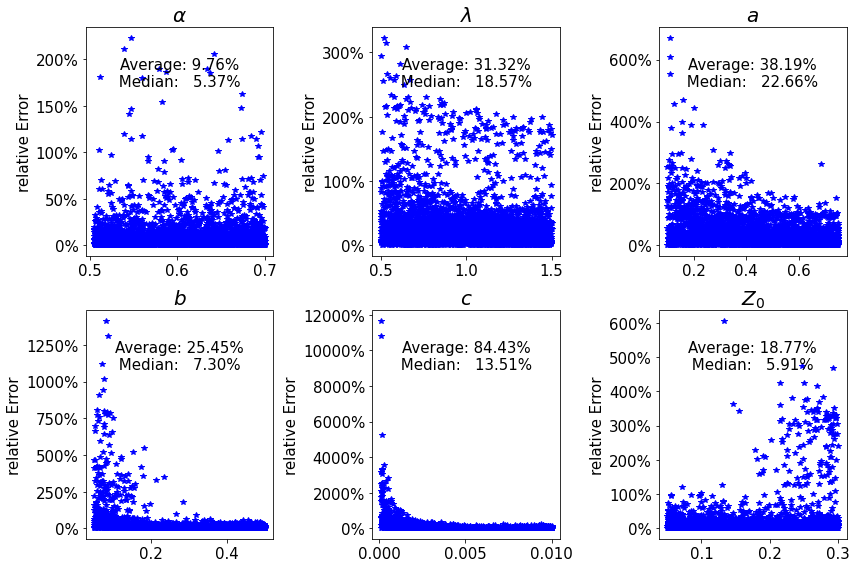

In [28]:
titles=["$\\alpha$","$\\lambda$","$a$","$b$", "$c$","$Z_0$"]
average=np.zeros([6,len(X_test)])
fig=plt.figure(figsize=(12,8))
for u in range(6):
    ax=plt.subplot(2,3,u+1)
    x=X_test[:len(X_test),u]
#     print(abs(LMParameters[:1800,u]))
#     print(100*np.abs(LMParameters[:1800,u]))
    plt.plot(x,100*np.abs(LMParameters[:len(X_test),u]-x)/np.abs(x),'b*')
    average[u,:]=np.abs(LMParameters[:len(X_test),u]-x)/np.abs(x)
    
    plt.title(titles[u],fontsize=20)
    plt.ylabel('relative Error',fontsize=15)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.tick_params(axis='both', which='minor', labelsize=15)
    plt.text(0.5, 0.8, 'Average: %1.2f%%\n Median:   %1.2f%% '%(np.mean(100*average[u,:]),np.quantile(100*average[u,:],0.5)), horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize=15)
plt.tight_layout()

# plt.savefig('HestonParameterRelativeErrors.png', dpi=300)
plt.show()

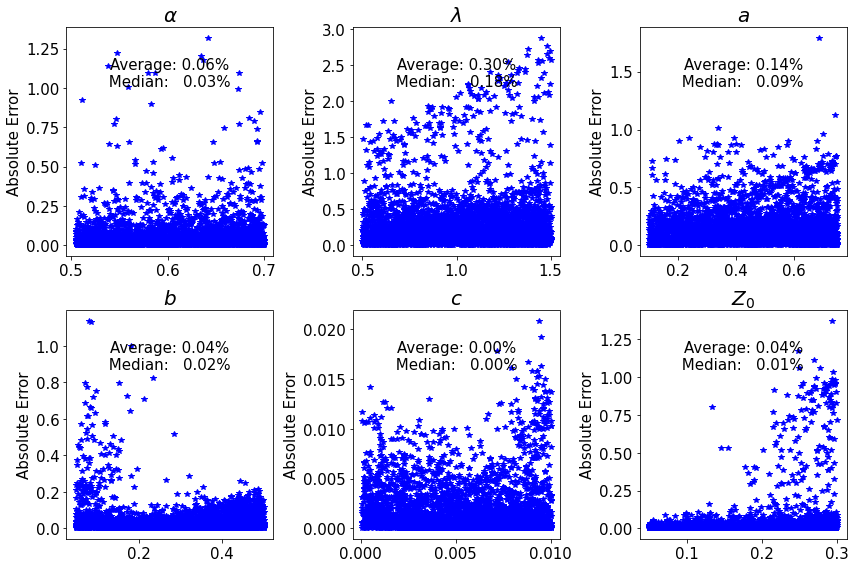

In [29]:
titles=["$\\alpha$","$\\lambda$","$a$","$b$", "$c$","$Z_0$"]
average=np.zeros([6,len(X_test)])
fig=plt.figure(figsize=(12,8))
for u in range(6):
    ax=plt.subplot(2,3,u+1)
    y=X_test[:len(X_test),u]
    plt.plot(y,np.abs(LMParameters[:len(X_test),u]-y),'b*')
    average[u,:]=np.abs(LMParameters[:len(X_test),u]-y)
    
    plt.title(titles[u],fontsize=20)
    plt.ylabel('Absolute Error',fontsize=15)
    #plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.tick_params(axis='both', which='minor', labelsize=15)
    plt.text(0.5, 0.8, 'Average: %1.2f%%\n Median:   %1.2f%% '%(np.mean(average[u,:]),np.quantile(average[u,:],0.5)), horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize=15)
plt.tight_layout()

# plt.savefig('HestonParameterAbsoluteErrors.png', dpi=300)
plt.show()

In [ ]:
6+++++++++++++++++++++++++9